In [1]:
import tensorflow as tf
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
images=np.load('/kaggle/input/numpy-array/Images.npy',mmap_mode='r')

In [3]:
masks=np.load('/kaggle/input/numpy-array/Masks(1).npy',mmap_mode='r')

In [4]:
len(masks),len(images)

(30422, 30422)

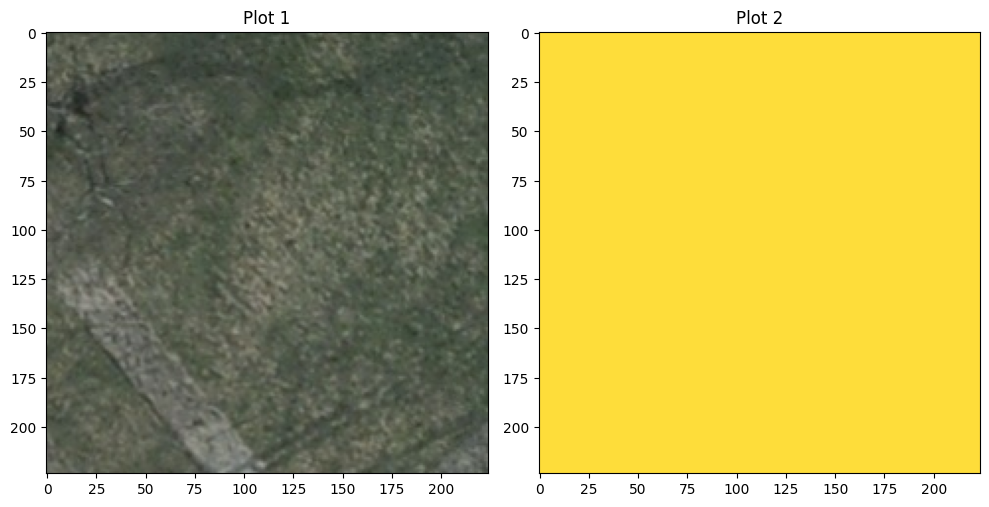

In [5]:
seed=3
num=np.random.randint(0,len(images))
import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 8))

# Access each subplot and plot something
axs[0].imshow(images[num])
axs[0].set_title('Plot 1')

axs[1].imshow(masks[num])
axs[1].set_title('Plot 2')


plt.tight_layout()

# Display the figure
plt.show()


In [6]:
class_indices={'Water':"50E3C2",'Land' : "F5A623",'Road' : 'DE597F','Building' : 'D0021B','Vegetation' : "417505",'Unlabeled' : "9B9B9B"}

In [7]:
#Convert HEX to RGB array

a=int('3C', 16)  #3C with base 16. Should return 60.
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155


60


In [8]:
Building,Land

(array([ 60,  16, 152]), array([132,  41, 246]))

In [9]:
!pip install segmentation_models

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.3 MB/s eta 0:00:00


In [10]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [11]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
import segmentation_models as sm
from PIL import Image
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import cv2
import numpy as np
import shutil
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

Segmentation Models: using `tf.keras` framework.


In [12]:
list_1=[Water,Land,Road,Building,Vegetation,Unlabeled]
new_list=[str(i) for i in list_1]

In [13]:
print("list",list_1)
print('new_list',new_list)

list [array([226, 169,  41]), array([132,  41, 246]), array([110, 193, 228]), array([ 60,  16, 152]), array([254, 221,  58]), array([155, 155, 155])]
new_list ['[226 169  41]', '[132  41 246]', '[110 193 228]', '[ 60  16 152]', '[254 221  58]', '[155 155 155]']


In [14]:
le=LabelEncoder()

In [15]:
encoder_dict=dict()
count=0
for i in class_indices.keys():
    encoder_dict[i]=count
    count+=1

In [16]:
encoder_dict

{'Water': 0,
 'Land': 1,
 'Road': 2,
 'Building': 3,
 'Vegetation': 4,
 'Unlabeled': 5}

In [17]:
new_values=to_categorical(list(encoder_dict.values()))

In [18]:
new_values

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [19]:
count=0
for i in encoder_dict.keys():
    encoder_dict[i]=new_values[count]
    count+=1

In [20]:
encoder_dict

{'Water': array([1., 0., 0., 0., 0., 0.]),
 'Land': array([0., 1., 0., 0., 0., 0.]),
 'Road': array([0., 0., 1., 0., 0., 0.]),
 'Building': array([0., 0., 0., 1., 0., 0.]),
 'Vegetation': array([0., 0., 0., 0., 1., 0.]),
 'Unlabeled': array([0., 0., 0., 0., 0., 1.])}

In [21]:
count=0
new_dict=dict()
for j in encoder_dict.values():
    new_dict[new_list[count]]=j
    count+=1

In [22]:
def checker_helper(s):
    s = s.strip("[]")
    s_list = s.split()
    int_list = list(map(int, s_list))
    return np.array(int_list)

In [23]:
new_dict

{'[226 169  41]': array([1., 0., 0., 0., 0., 0.]),
 '[132  41 246]': array([0., 1., 0., 0., 0., 0.]),
 '[110 193 228]': array([0., 0., 1., 0., 0., 0.]),
 '[ 60  16 152]': array([0., 0., 0., 1., 0., 0.]),
 '[254 221  58]': array([0., 0., 0., 0., 1., 0.]),
 '[155 155 155]': array([0., 0., 0., 0., 0., 1.])}

In [24]:
weights=[1/6]*6
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [25]:
BATCH_SIZE=8

def jacard_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)


In [26]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, models

def build_unet(input_shape=(224, 224, 3), classes=6):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bottleneck
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    
    # Decoder
    up5 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4)
    concat5 = layers.concatenate([up5, conv3])
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)
    
    up6 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    concat6 = layers.concatenate([up6, conv2])
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)
    
    up7 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    concat7 = layers.concatenate([up7, conv1])
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)
    
    outputs = layers.Conv2D(classes, 1, activation='softmax')(conv7)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model




In [27]:
metrics=['accuracy', jacard_coef]

In [28]:
def get_model():
    return build_unet(input_shape=(224, 224, 3), classes=6)

In [29]:
model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 56, 56,    │    524,544 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56, 56,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 56, 56,    │  1,179,904 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 56, 56,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 112, 112,  │    131,200 │ conv2d_9[0][0]  

 Total params: 7,697,670 (29.36 MB)

 Trainable params: 7,697,670 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
from sklearn.model_selection import train_test_split
def split_data(images, masks, val_split=0.2, seed=3):
    return train_test_split(images, masks, test_size=val_split, random_state=seed)
train_images, val_images, train_masks, val_masks = split_data(images, masks, val_split=0.2)

# Create generators


In [31]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
seed=3
def color_to_one(mask, num_class=6):
    fake = np.zeros((mask.shape[0], mask.shape[1], mask.shape[2], num_class))
    for i, j in new_dict.items():
        condition = np.all(mask == checker_helper(i), axis=-1)
        fake[condition] = j
    return fake

def train_generator(images, masks, batch_size=3, img_size=(224, 224), num_class=6, seed=3):
    data_gen_args = dict(
        horizontal_flip=True,        
        vertical_flip=True,          
        rotation_range=15,           
        width_shift_range=0.1,       
        height_shift_range=0.1,      
        zoom_range=0.2,              
        shear_range=0.1,             
        fill_mode='reflect'          
    )
    
    images = np.array(images)
    masks = np.array(masks)
    
    image_datagen = ImageDataGenerator(**data_gen_args)
   
    
    np.random.seed(seed)
    
    while True:
        indices = np.arange(images.shape[0])
        np.random.shuffle(indices)  # Shuffle the indices at the start of each epoch

        for start in range(0, len(indices), batch_size):
            end = min(start + batch_size, len(indices))
            batch_indices = indices[start:end]
            
            batch_images = images[batch_indices]
            batch_masks = masks[batch_indices]
            
            transformed_images = np.zeros_like(batch_images)
            transformed_masks = np.zeros_like(batch_masks)
            
            for i in range(len(batch_indices)):
                seed_i = np.random.randint(1e6)
                
                transformed_images[i] = image_datagen.random_transform(batch_images[i], seed=seed_i)
                transformed_masks[i] = image_datagen.random_transform(batch_masks[i], seed=seed_i)
            
            transformed_images = transformed_images / 255.0
            transformed_masks = color_to_one(transformed_masks.astype(int), num_class)
            
            yield transformed_images, transformed_masks
def validation_generator(images, masks, batch_size=3, img_size=(224, 224), num_class=6, seed=3):
    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()
    
    np.random.seed(seed)
    
    while True:
        indices = np.arange(images.shape[0])
        np.random.shuffle(indices)  # Shuffle the indices at the start of each epoch

        for start in range(0, len(indices), batch_size):
            end = min(start + batch_size, len(indices))
            batch_indices = indices[start:end]
            
            batch_images = np.array(images[batch_indices])
            batch_masks = np.array(masks[batch_indices])
            
            batch_images = image_datagen.standardize(batch_images)
            batch_masks = mask_datagen.standardize(batch_masks)
            
            batch_images = batch_images / 255.0
            batch_masks = color_to_one(batch_masks.astype(int), num_class)
            
            yield batch_images, batch_masks


In [32]:
train_gen = train_generator(train_images, train_masks, batch_size=BATCH_SIZE, img_size=(224, 224), num_class=6, seed=3)
val_gen = validation_generator(val_images, val_masks, batch_size=BATCH_SIZE, img_size=(224, 224), num_class=6)

# Fetch and visualize the first batch
val_img_batch, val_mask_batch = next(val_gen)


In [33]:
def decoder(predicted_mask):
    argmaxed=np.argmax(predicted_mask,axis=-1)
    argmaxed=np.squeeze(argmaxed,axis=0)
    new_dict_2=dict()
    count=0
    for i, j in new_dict.items():
        new_dict_2[count]=checker_helper(i)
        count+=1
    rgb_image = np.zeros((224, 224, 3), dtype=np.uint8)
    for key, color in new_dict_2.items():
        rgb_image[argmaxed == key] = color
    return rgb_image

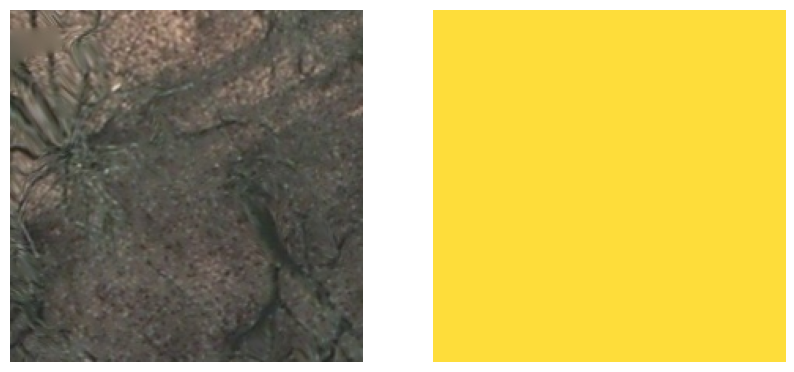

In [34]:
num=np.random.randint(0,BATCH_SIZE)

fig,axes=plt.subplots(1,2,figsize=(10,6))
axes[0].imshow(val_img_batch[num])
axes[1].imshow(decoder(np.expand_dims(val_mask_batch[num],axis=0)))
axes[0].set_axis_off()
axes[1].set_axis_off()



In [35]:
from tensorflow.keras.callbacks import EarlyStopping

In [36]:

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_check=ModelCheckpoint('/kaggle/working/check_model.keras',monitor='val_jacard_coef',save_best_only=True,mode='max')

In [37]:
model.fit(train_gen,batch_size=BATCH_SIZE,epochs=30,validation_data=val_gen,callbacks=[model_check,reduce_lr,early_stop],steps_per_epoch=1000,validation_steps=100)

Epoch 1/30


I0000 00:00:1725863720.013547      76 service.cc:145] XLA service 0x7ca7380042a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725863720.013624      76 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725863720.013631      76 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1725863752.412156      76 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_10', 608 bytes spill stores, 532 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_slice_fusion_1', 192 bytes spill stores, 192 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_14', 208 bytes spill stores, 208 bytes spill loads

I0000 00:00:1725863752.422850      76 device_compiler.h:188] Compiled cluster using XLA!  This line is log

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 317s 279ms/step - accuracy: 0.5052 - jacard_coef: 0.2684 - loss: 0.9858 - val_accuracy: 0.6636 - val_jacard_coef: 0.3952 - val_loss: 0.9605 - learning_rate: 0.0010
Epoch 2/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 272s 272ms/step - accuracy: 0.6600 - jacard_coef: 0.4209 - loss: 0.9631 - val_accuracy: 0.7045 - val_jacard_coef: 0.4598 - val_loss: 0.9572 - learning_rate: 0.0010
Epoch 3/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 271s 271ms/step - accuracy: 0.6729 - jacard_coef: 0.4432 - loss: 0.9579 - val_accuracy: 0.6995 - val_jacard_coef: 0.4742 - val_loss: 0.9562 - learning_rate: 0.0010
Epoch 4/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 282s 282ms/step - accuracy: 0.6816 - jacard_coef: 0.4568 - loss: 0.9558 - val_accuracy: 0.6797 - val_jacard_coef: 0.4365 - val_loss: 0.9578 - learning_rate: 0.0010
Epoch 5/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 270s 270ms/step - accuracy: 0.6814 - jacard_coef: 0.4581 - loss: 0.9551 - val_accuracy: 0.7015 - val_jacard_coef: 0.4942 - val_loss: 0.9534 - lea

In [38]:
from tensorflow.keras.models import load_model

In [39]:
model=load_model('/kaggle/working/check_model.keras',compile =False)

In [40]:
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)

In [41]:
from PIL import Image

new_dict={'[226 169  41]': np.array([1., 0., 0., 0., 0., 0.]),
 '[132  41 246]': np.array([0., 1., 0., 0., 0., 0.]),
 '[110 193 228]': np.array([0., 0., 1., 0., 0., 0.]),
 '[ 60  16 152]': np.array([0., 0., 0., 1., 0., 0.]),
 '[254 221  58]': np.array([0., 0., 0., 0., 1., 0.]),
 '[155 155 155]': np.array([0., 0., 0., 0., 0., 1.])}


def checker_helper(s):
    s = s.strip("[]")
    s_list = s.split()
    int_list = list(map(int, s_list))
    return np.array(int_list)


def decoder(predicted_mask):
    argmaxed=np.argmax(predicted_mask,axis=-1)
    argmaxed=np.squeeze(argmaxed,axis=0)
    new_dict_2=dict()
    count=0
    for i, j in new_dict.items():
        new_dict_2[count]=checker_helper(i)
        count+=1
    rgb_image = np.zeros((224, 224, 3), dtype=np.uint8)
    for key, color in new_dict_2.items():
        rgb_image[argmaxed == key] = color
    return rgb_image

In [42]:
path='/kaggle/input/dubai-dataset-patched-images-2242243/Data/Images/image_part_001 (4)_patch_2_1.png'

In [43]:
image=Image.open(path)
image = image.convert("RGB")

In [44]:

new_dict={'[226 169  41]': np.array([1., 0., 0., 0., 0., 0.]),
 '[132  41 246]': np.array([0., 1., 0., 0., 0., 0.]),
 '[110 193 228]': np.array([0., 0., 1., 0., 0., 0.]),
 '[ 60  16 152]': np.array([0., 0., 0., 1., 0., 0.]),
 '[254 221  58]': np.array([0., 0., 0., 0., 1., 0.]),
 '[155 155 155]': np.array([0., 0., 0., 0., 0., 1.])}
def checker_helper(s):
    s = s.strip("[]")
    s_list = s.split()
    int_list = list(map(int, s_list))
    return np.array(int_list)

In [45]:
def decoder(predicted_mask):
    argmaxed=np.argmax(predicted_mask,axis=-1)
    argmaxed=np.squeeze(argmaxed,axis=0)
    new_dict_2=dict()
    count=0
    for i, j in new_dict.items():
        new_dict_2[count]=checker_helper(i)
        count+=1
    rgb_image = np.zeros((224, 224, 3), dtype=np.uint8)
    for key, color in new_dict_2.items():
        rgb_image[argmaxed == key] = color
    return rgb_image

In [46]:
def plot_comparision(image,predicted):
    fig,axes=plt.subplots(1,2,figsize=(10,6))
    axes[0].imshow(image)
    axes[1].imshow(decoder(predicted))
    axes[0].set_axis_off()
    axes[1].set_axis_off()


In [47]:
patch_size=224

In [48]:
SIZE_X = (image.size[0]//patch_size)*patch_size #Nearest size divisible by our patch size
SIZE_Y = (image.size[1]//patch_size)*patch_size

In [49]:
image = image.crop((0 ,0, SIZE_X, SIZE_Y)) 
image = np.array(image)

In [50]:
!pip install patchify

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [51]:
from patchify import patchify

In [52]:
print("Now patchifying image")
patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size) 

Now patchifying image


In [53]:
predicted_array = []
patches_img=np.squeeze(patches_img,axis=2)
# Iterate over all patches
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img = patches_img[i, j, :, :] / 255.0  # Normalize patch
        predicted = model.predict(np.expand_dims(single_patch_img,axis=0))  # Predict
        predicted_rgb = decoder(predicted)  # Decode the prediction
        predicted_array.append(predicted_rgb)  # Store the decoded RGB prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


In [54]:
predicted_patches = np.array(predicted_array).reshape(patches_img.shape[0], patches_img.shape[1], 224, 224, 3)


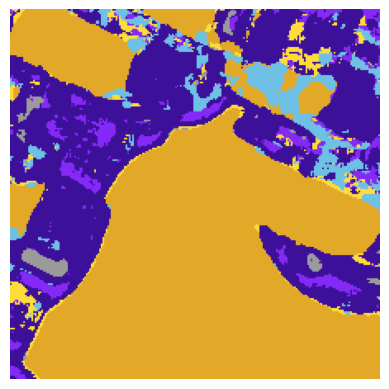

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Dimensions
patch_height = 224
patch_width = 224
num_patches_height = patches_img.shape[0]
num_patches_width = patches_img.shape[1]

# Create an empty image of the right size
reconstructed_image = np.zeros((num_patches_height * patch_height, num_patches_width * patch_width, 3), dtype=np.uint8)

# Place patches into the image
for i in range(num_patches_height):
    for j in range(num_patches_width):
        reconstructed_image[i*patch_height:(i+1)*patch_height, j*patch_width:(j+1)*patch_width, :] = predicted_patches[i, j]

# Display the result
plt.imshow(reconstructed_image)
plt.axis('off')
plt.show()


In [56]:
def plot_comparision(image,predicted):
    fig,axes=plt.subplots(1,2,figsize=(20,20))
    axes[0].imshow(image)
    axes[1].imshow(predicted)
    axes[0].set_axis_off()
    axes[1].set_axis_off()

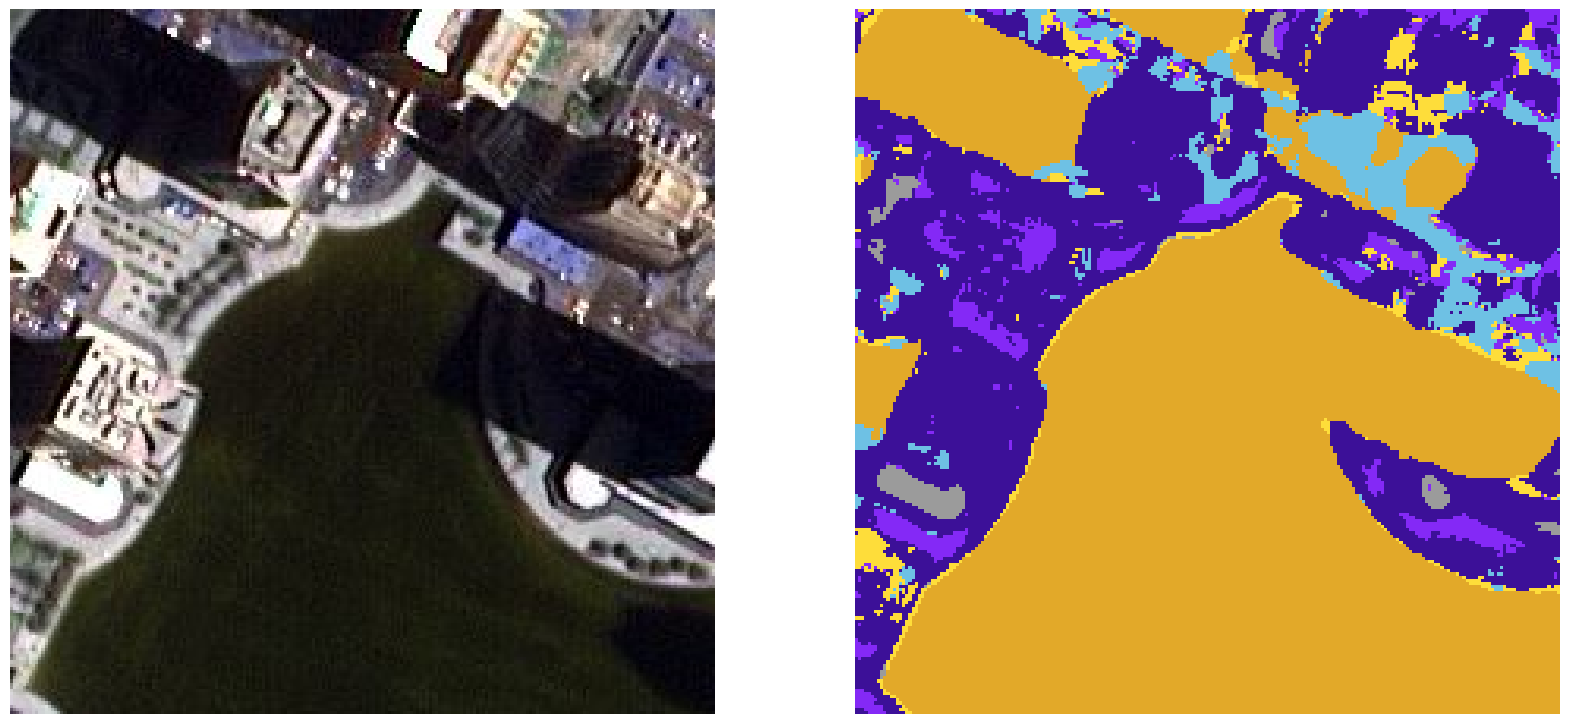

In [57]:
plot_comparision(image,reconstructed_image)